In [8]:
# --- Project Initialization and Environment Setup for Data Cleaning ---
import sys
import os
from pathlib import Path

# --- Add Project Root to sys.path ---
project_root = Path.cwd().parent.resolve()
project_root_str = str(project_root)
if project_root_str not in sys.path:
    sys.path.insert(0, project_root_str)

# --- Core Imports ---
import logging
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text

# Project-specific import
from src.database.db_connection import get_database_engine

# --- Configuration and Logging ---
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("data_cleaning_notebook")

OUTPUT_DIR = Path("output") # Relative to notebooks/
OUTPUT_DIR.mkdir(exist_ok=True)

# Visualization styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Environment initialized for data cleaning.")

# --- Database Connection ---
try:
    engine = get_database_engine()
    logger.info("Database engine acquired for data cleaning.")
    with engine.connect() as conn:
        result = conn.execute(text("SELECT current_database(), current_user;"))
        db_info_row = result.fetchone()
        if db_info_row:
            db_name, db_user = db_info_row
            print(f"✅ Connected to database '{db_name}' as user '{db_user}'.")
        else:
            print("⚠️  Connected to database (info retrieval returned no rows).")
except Exception as e:
    logger.error(f"Database connection failed: {e}", exc_info=True)
    print(f"❌ Error connecting to database: {e}")
    raise


INFO:src.database.db_connection:Creating database engine for database=banking_analytics_db host=localhost port=5432 driver=postgresql+psycopg
INFO:data_cleaning_notebook:Database engine acquired for data cleaning.


✅ Environment initialized for data cleaning.
✅ Connected to database 'banking_analytics_db' as user 'bank_user'.


In [9]:
# --- Load Data from PostgreSQL into Pandas DataFrames for Cleaning ---
print("📥 Loading data from database for cleaning...")

dataframes_cleaning = {}

try:
    queries_cleaning = {
        "customers": "SELECT * FROM customers;",
        "accounts": "SELECT * FROM accounts;",
        "transactions": "SELECT * FROM transactions;" # Load full dataset
    }

    for table_name, query in queries_cleaning.items():
        logger.info(f"Loading data for cleaning table: {table_name}")
        df = pd.read_sql(query, engine)
        # Ensure datetime columns are parsed correctly if not already
        if table_name == 'customers' and 'account_open_date' in df.columns:
             df['account_open_date'] = pd.to_datetime(df['account_open_date'])
        if table_name == 'transactions' and 'transaction_date' in df.columns:
             df['transaction_date'] = pd.to_datetime(df['transaction_date'])
        dataframes_cleaning[table_name] = df
        print(f"   ✅ Loaded {len(df):,} rows into DataFrame '{table_name}'")

    # Assign DataFrames to convenient variables
    df_customers_clean = dataframes_cleaning['customers']
    df_accounts_clean = dataframes_cleaning['accounts']
    df_transactions_clean = dataframes_cleaning['transactions']

    print("✅ All data loaded for cleaning.")
    print("-" * 20)

except Exception as e:
    logger.error(f"Error loading data for cleaning: {e}", exc_info=True)
    print(f"❌ Error loading  {e}")
    raise


INFO:data_cleaning_notebook:Loading data for cleaning table: customers
INFO:data_cleaning_notebook:Loading data for cleaning table: accounts
INFO:data_cleaning_notebook:Loading data for cleaning table: transactions


📥 Loading data from database for cleaning...
   ✅ Loaded 500 rows into DataFrame 'customers'
   ✅ Loaded 627 rows into DataFrame 'accounts'
   ✅ Loaded 4,912 rows into DataFrame 'transactions'
✅ All data loaded for cleaning.
--------------------


# Data Cleaning & Preparation

This notebook focuses on cleaning the data loaded from the database using Python and Pandas. This includes handling missing values, treating outliers, ensuring data type consistency, and performing any necessary standardization.

Based on Phase 2 analysis, major integrity issues in key columns were not found. This notebook will demonstrate common cleaning techniques and apply them where relevant or for practice.

## 1. Initial Data Review & Integrity Checks

Re-verify basic data integrity on the loaded DataFrames before applying transformations.

In [10]:
# --- 1. Initial Data Review & Integrity Checks ---
print("--- Re-verifying Data Integrity ---")

# Function to check for common issues
def check_dataframe_integrity(df_name, df):
    print(f"\n--- Checking DataFrame: {df_name} ---")
    print(f"Shape: {df.shape}")
    # Check for NULLs in all columns
    null_summary = df.isnull().sum()
    if null_summary.any():
        print("NULL values found:")
        print(null_summary[null_summary > 0])
    else:
        print("✅ No NULL values found in any column.")

    # Check for duplicates in the entire DataFrame (less common, but possible)
    dup_rows = df.duplicated().sum()
    if dup_rows > 0:
        print(f"⚠️  WARNING: Found {dup_rows:,} duplicate rows.")
    else:
        print("✅ No duplicate rows found.")

    # Check data types
    print("\nData Types:")
    print(df.dtypes)

# Check each DataFrame
check_dataframe_integrity("Customers (for cleaning)", df_customers_clean)
check_dataframe_integrity("Accounts (for cleaning)", df_accounts_clean)
check_dataframe_integrity("Transactions (for cleaning)", df_transactions_clean)


--- Re-verifying Data Integrity ---

--- Checking DataFrame: Customers (for cleaning) ---
Shape: (500, 4)
✅ No NULL values found in any column.
✅ No duplicate rows found.

Data Types:
customer_id                  object
customer_name                object
region                       object
account_open_date    datetime64[ns]
dtype: object

--- Checking DataFrame: Accounts (for cleaning) ---
Shape: (627, 4)
✅ No NULL values found in any column.
✅ No duplicate rows found.

Data Types:
account_id       object
customer_id      object
account_type     object
balance         float64
dtype: object

--- Checking DataFrame: Transactions (for cleaning) ---
Shape: (4912, 7)
✅ No NULL values found in any column.
✅ No duplicate rows found.

Data Types:
transaction_id                    object
account_id                        object
transaction_date          datetime64[ns]
transaction_type                  object
amount                           float64
merchant_category_code            object
des

## 2. Outlier Treatment

Apply techniques to handle outliers identified in Phase 2 (e.g., `transactions.amount`). We'll demonstrate capping/flooring based on IQR.

--- Outlier Treatment ---

--- Treating Outliers in 'amount' ---
Original range: 3.99 to 16211.03
IQR: 537.11
Lower Bound: -697.55, Upper Bound: 1450.88
Number of outliers detected: 408
New range after capping/flooring: 3.99 to 1450.88


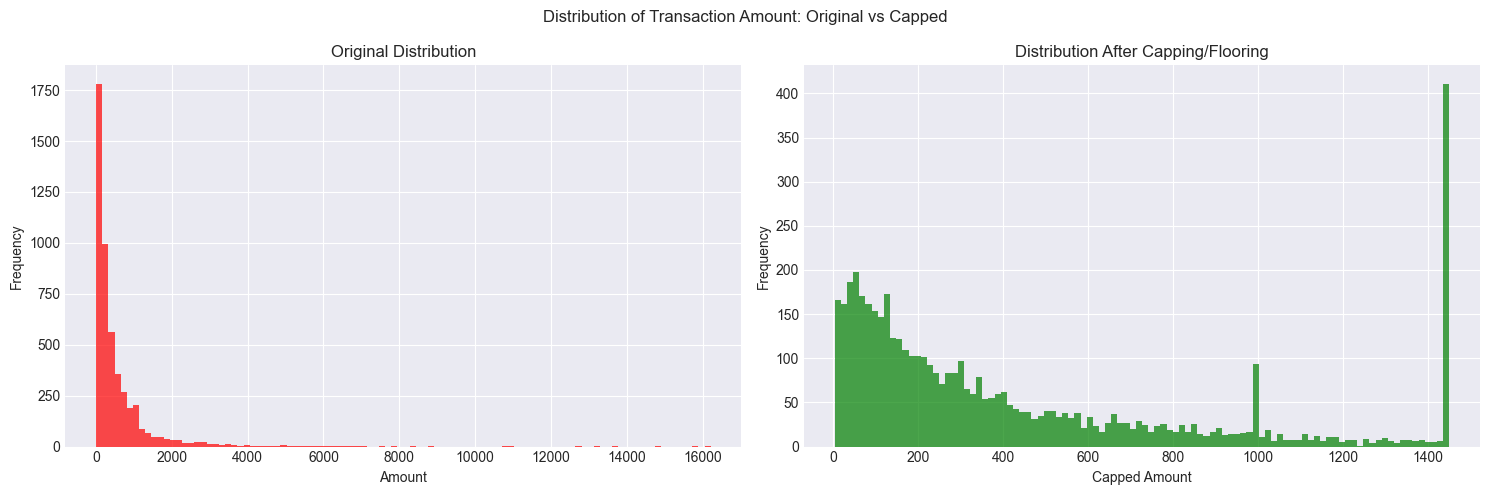

💡 Outlier treatment (capping/flooring) demonstrated on a copy of the data.
   The main DataFrame was not modified. Apply to the main DF if needed.


In [11]:
# --- 2. Outlier Treatment ---
print("--- Outlier Treatment ---")

# --- Example: Cap/Floor Transaction Amounts using IQR ---
column_to_treat = 'amount'
df_txn_for_outliers = df_transactions_clean.copy() # Work on a copy

print(f"\n--- Treating Outliers in '{column_to_treat}' ---")
print(f"Original range: {df_txn_for_outliers[column_to_treat].min():.2f} to {df_txn_for_outliers[column_to_treat].max():.2f}")

# Calculate IQR
Q1 = df_txn_for_outliers[column_to_treat].quantile(0.25)
Q3 = df_txn_for_outliers[column_to_treat].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR: {IQR:.2f}")
print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")

# Count outliers
outliers_condition = (df_txn_for_outliers[column_to_treat] < lower_bound) | (df_txn_for_outliers[column_to_treat] > upper_bound)
num_outliers = outliers_condition.sum()
print(f"Number of outliers detected: {num_outliers:,}")

# Apply Capping/Flooring
df_txn_for_outliers[f'{column_to_treat}_capped'] = df_txn_for_outliers[column_to_treat].clip(lower=lower_bound, upper=upper_bound)

print(f"New range after capping/flooring: {df_txn_for_outliers[f'{column_to_treat}_capped'].min():.2f} to {df_txn_for_outliers[f'{column_to_treat}_capped'].max():.2f}")

# Optional: Visualize the effect (before/after)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle(f'Distribution of Transaction Amount: Original vs Capped')

axes[0].hist(df_txn_for_outliers[column_to_treat], bins=100, alpha=0.7, color='red')
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')
# axes[0].set_yscale('log') # Use log scale if highly skewed

axes[1].hist(df_txn_for_outliers[f'{column_to_treat}_capped'], bins=100, alpha=0.7, color='green')
axes[1].set_title('Distribution After Capping/Flooring')
axes[1].set_xlabel('Capped Amount')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Update the main DataFrame if the treatment is accepted
# For now, we just demonstrated the technique.
# df_transactions_clean['amount'] = df_txn_for_outliers['amount_capped']
print("💡 Outlier treatment (capping/flooring) demonstrated on a copy of the data.")
print("   The main DataFrame was not modified. Apply to the main DF if needed.")


## 3. Missing Value Treatment

Although minimal from Phase 2, demonstrate how missing values would be handled. We'll check for and potentially impute missing data in a non-key column like `description`.

In [12]:
# --- 3. Missing Value Treatment ---
print("--- Missing Value Treatment ---")

# --- Example: Handle missing descriptions ---
column_to_check = 'description'
if column_to_check in df_transactions_clean.columns:
    missing_desc_count = df_transactions_clean[column_to_check].isnull().sum()
    print(f"\n--- Checking Missing Values in '{column_to_check}' ---")
    print(f"Number of missing descriptions: {missing_desc_count:,}")

    if missing_desc_count > 0:
        print("Applying treatment for missing descriptions...")
        # Option 1: Impute with a placeholder
        # df_transactions_clean[column_to_check].fillna("No Description Provided", inplace=True)
        # print("   ✅ Missing descriptions filled with 'No Description Provided'.")

        # Option 2: Impute with mode (most frequent value)
        mode_desc = df_transactions_clean[column_to_check].mode()
        if not mode_desc.empty:
        # df_transactions_clean[column_to_check].fillna(mode_desc.iloc[0], inplace=True)
        # print(f"   ✅ Missing descriptions filled with mode: '{mode_desc.iloc[0]}'.")

        # Option 3: Forward-fill or Backward-fill (if data is ordered meaningfully)
        # Not typically suitable for transaction data descriptions.

        # Option 4: Drop rows (if missing data is not significant and dropping is acceptable)
        # initial_count = len(df_transactions_clean)
        # df_transactions_clean.dropna(subset=[column_to_check], inplace=True)
        # final_count = len(df_transactions_clean)
        # print(f"   ✅ Dropped {initial_count - final_count:,} rows with missing descriptions.")

        # For demonstration, let's just show the count and state no action is taken
        # as missing descriptions might be acceptable depending on use case.
          print("   ℹ️  No automatic treatment applied. Review and choose strategy based on context.")
    else:
        print("✅ No missing values found in 'description'. No treatment needed.")
else:
    print(f"⚠️  Column '{column_to_check}' not found in transactions DataFrame.")

# Check overall NULLs again after any potential treatment
print("\n--- Re-checking for NULLs after treatment ---")
check_dataframe_integrity("Transactions (after treatment check)", df_transactions_clean)


--- Missing Value Treatment ---

--- Checking Missing Values in 'description' ---
Number of missing descriptions: 0
✅ No missing values found in 'description'. No treatment needed.

--- Re-checking for NULLs after treatment ---

--- Checking DataFrame: Transactions (after treatment check) ---
Shape: (4912, 7)
✅ No NULL values found in any column.
✅ No duplicate rows found.

Data Types:
transaction_id                    object
account_id                        object
transaction_date          datetime64[ns]
transaction_type                  object
amount                           float64
merchant_category_code            object
description                       object
dtype: object


## 4. Data Type Consistency & Standardization

Ensure columns have the correct and efficient data types. Standardize text data if necessary.

In [13]:
# --- 4. Data Type Consistency & Standardization ---
print("--- Data Type Consistency & Standardization ---")

# --- Ensure Date Columns are datetime ---
# This was done during loading, but good to confirm/redo if needed.
# df_customers_clean['account_open_date'] = pd.to_datetime(df_customers_clean['account_open_date'])
# df_transactions_clean['transaction_date'] = pd.to_datetime(df_transactions_clean['transaction_date'])
print("✅ Date columns confirmed as datetime64[ns] (assumed from loading step).")

# --- Optimize String Columns to 'category' dtype (if beneficial) ---
# This can save memory for columns with low cardinality relative to row count.
print("\n--- Optimizing String Columns (Category Dtype) ---")

# Check Accounts
print("Checking 'accounts' DataFrame:")
for col in df_accounts_clean.select_dtypes(include=['object']).columns:
    unique_count = df_accounts_clean[col].nunique()
    total_count = len(df_accounts_clean)
    ratio = unique_count / total_count
    print(f"  Column '{col}': {unique_count:,} unique / {total_count:,} total (ratio: {ratio:.4f})")
    # Heuristic: If ratio is low (e.g., < 0.5), consider category
    if ratio < 0.5 and total_count > 100: # Avoid for tiny datasets
        # df_accounts_clean[col] = df_accounts_clean[col].astype('category')
        # print(f"    -> Considered converting '{col}' to 'category' dtype.")
        print(f"    -> Could convert '{col}' to 'category' dtype for memory efficiency.")

# Check Transactions
print("\nChecking 'transactions' DataFrame:")
for col in df_transactions_clean.select_dtypes(include=['object']).columns:
    unique_count = df_transactions_clean[col].nunique()
    total_count = len(df_transactions_clean)
    ratio = unique_count / total_count
    print(f"  Column '{col}': {unique_count:,} unique / {total_count:,} total (ratio: {ratio:.4f})")
    if ratio < 0.1 and total_count > 1000: # Stricter condition for transactions
         # df_transactions_clean[col] = df_transactions_clean[col].astype('category')
         # print(f"    -> Considered converting '{col}' to 'category' dtype.")
         print(f"    -> Could convert '{col}' to 'category' dtype for memory efficiency.")

# --- Standardize Text Data (Example) ---
print("\n--- Standardizing Text Data ---")
# Example: Trim whitespace and ensure consistent casing for 'description'
if 'description' in df_transactions_clean.columns:
    # Store original sample for comparison
    original_sample = df_transactions_clean['description'].head(3).copy()
    # Apply standardization
    df_transactions_clean['description'] = df_transactions_clean['description'].str.strip() # Remove leading/trailing whitespace
    # df_transactions_clean['description'] = df_transactions_clean['description'].str.upper() # Example: Make uppercase
    # df_transactions_clean['description'] = df_transactions_clean['description'].str.title() # Example: Title Case
    print("✅ Text standardization (strip whitespace) applied to 'description'.")
    # Show effect
    print("Sample before standardization:")
    display(original_sample.to_frame())
    print("Sample after standardization:")
    display(df_transactions_clean['description'].head(3).to_frame())
else:
    print("⚠️  'description' column not found for text standardization.")

# Final check of dtypes
print("\n--- Final Data Types Check ---")
print("Accounts dtypes:")
print(df_accounts_clean.dtypes)
print("\nTransactions dtypes:")
print(df_transactions_clean.dtypes)


--- Data Type Consistency & Standardization ---
✅ Date columns confirmed as datetime64[ns] (assumed from loading step).

--- Optimizing String Columns (Category Dtype) ---
Checking 'accounts' DataFrame:
  Column 'account_id': 627 unique / 627 total (ratio: 1.0000)
  Column 'customer_id': 500 unique / 627 total (ratio: 0.7974)
  Column 'account_type': 3 unique / 627 total (ratio: 0.0048)
    -> Could convert 'account_type' to 'category' dtype for memory efficiency.

Checking 'transactions' DataFrame:
  Column 'transaction_id': 4,912 unique / 4,912 total (ratio: 1.0000)
  Column 'account_id': 42 unique / 4,912 total (ratio: 0.0086)
    -> Could convert 'account_id' to 'category' dtype for memory efficiency.
  Column 'transaction_type': 5 unique / 4,912 total (ratio: 0.0010)
    -> Could convert 'transaction_type' to 'category' dtype for memory efficiency.
  Column 'merchant_category_code': 9 unique / 4,912 total (ratio: 0.0018)
    -> Could convert 'merchant_category_code' to 'category' 

,description
0,Deposit at Unknown
1,Transfer Out at Transfer
2,Deposit at Unknown


Sample after standardization:


,description
0,Deposit at Unknown
1,Transfer Out at Transfer
2,Deposit at Unknown



--- Final Data Types Check ---
Accounts dtypes:
account_id       object
customer_id      object
account_type     object
balance         float64
dtype: object

Transactions dtypes:
transaction_id                    object
account_id                        object
transaction_date          datetime64[ns]
transaction_type                  object
amount                           float64
merchant_category_code            object
description                       object
dtype: object


**Cell 12: Markdown (Cleaning Summary)**

```markdown
## Summary of Data Cleaning Steps

This notebook demonstrated several key data cleaning and preparation techniques using Python/Pandas:

1.  **Integrity Re-verification:** Confirmed no major NULL or duplicate issues in key columns.
2.  **Outlier Treatment:** Showed how to identify and treat outliers (e.g., in `transactions.amount`) using the IQR method (capping/flooring). The technique was applied to a copy for demonstration.
3.  **Missing Value Treatment:** Checked for missing values (e.g., in `description`) and outlined common treatment strategies (imputation, dropping) without applying them automatically.
4.  **Data Type Optimization:** Reviewed opportunities to convert string columns to `category` dtype for memory efficiency.
5.  **Text Standardization:** Applied whitespace trimming to the `description` field.

These steps ensure the data is in a consistent, clean format, ready for the next phase of feature engineering.
```